In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from data_handling.data_loader import load_mavir_data
from trainer_lib import Grid, grid_search
from models import Transformer
import utils

In [2]:
df = load_mavir_data('data/mavir_data/mavir.csv')
df['Power'] = utils.min_max_norm(df['Power'])
sample = utils.sample(df, 200, start_idx=0)

# imfs, residue = utils.apply_eemd(sample['Power'].to_numpy(), spline_kind='akima')

In [3]:
training_data = np.array(sample['Power'].to_numpy()[...,np.newaxis], dtype=np.float32)
# training_data_decomp = np.array(np.c_[imfs.transpose(), residue[...,np.newaxis]], dtype=np.float32)
# training_data_decomp_rem = np.array(np.c_[imfs[1:].transpose(), residue[...,np.newaxis]], dtype=np.float32)
# training_data_combined = np.array(np.c_[sample['Power'].to_numpy()[...,np.newaxis], imfs.transpose(), residue[...,np.newaxis]], dtype=np.float32)
# training_data_combined_rem = np.array(np.c_[sample['Power'].to_numpy()[...,np.newaxis], imfs[1:].transpose(), residue[...,np.newaxis]], dtype=np.float32)
# print(training_data.shape)
# print(training_data.dtype)
# print(training_data_decomp.shape)
# print(training_data_decomp.dtype)

In [4]:
params = {
'src_size' : [1],
'tgt_size' : [1],
'd_model' : [256], #, 256, 512],
'num_heads' : [4], # , 4, 8],
'num_layers' : [4], # , 2, 3],
'd_ff' : [1024], # , 1024, 2048],
'enc_seq_length' : [24], # , 96],
'dec_seq_length' : [8],
'dropout' : [0.2], # , 0.1, 0.15, 0.2],
}

grid = Grid(params)
models = grid_search(grid, Transformer, training_data, training_data, epochs=50, split=0.01)

67 1
Epoch: 1, Train Loss: 0.7154547240999011, Eval Loss: 0.32624131441116333
Epoch: 2, Train Loss: 0.30635326769616866, Eval Loss: 0.014011574909090996
Epoch: 3, Train Loss: 0.1999292754464679, Eval Loss: 0.007847367785871029
Epoch: 4, Train Loss: 0.16402340100871193, Eval Loss: 0.04953702911734581
Epoch: 5, Train Loss: 0.15737530754672155, Eval Loss: 0.007543300744146109
Epoch: 6, Train Loss: 0.1398218646645546, Eval Loss: 0.022890688851475716
Epoch: 7, Train Loss: 0.1507711112499237, Eval Loss: 0.010128547437489033
Epoch: 8, Train Loss: 0.11619410415490468, Eval Loss: 0.00583846727386117
Epoch: 9, Train Loss: 0.12270850522650614, Eval Loss: 0.04581158235669136
Epoch: 10, Train Loss: 0.11821256660752825, Eval Loss: 0.006712642032653093
Epoch: 11, Train Loss: 0.10321099476681814, Eval Loss: 0.014916361309587955
Epoch: 12, Train Loss: 0.11394091778331333, Eval Loss: 0.029023637995123863
Epoch: 13, Train Loss: 0.1002517119050026, Eval Loss: 0.010112648829817772
Epoch: 14, Train Loss: 0.

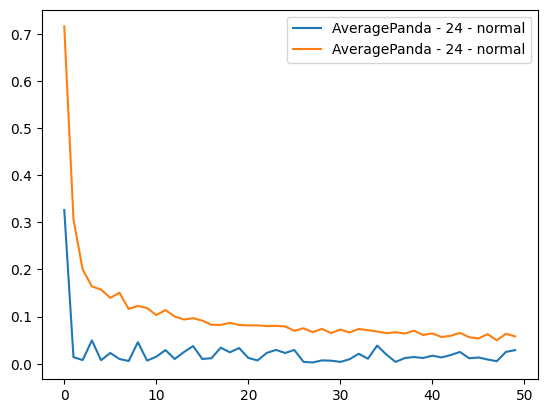

In [5]:

#for model in models_decomp_combined:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - combined')

#for model in models_decomp_combined_rem:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - combined rem')

#for model in models_decomp_rem:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - rem')

#for model in models_decomp:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - decomp')

for model in models:
    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - normal')
    plt.plot(model['metrics']['train_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - normal')

plt.legend()
plt.show()

/tmp/ipykernel_6695/4063984334.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(torch.concat((ones, torch.tensor(training_data[np.newaxis, shift+look_back:shift+look_back+pred-1,:])), dim=1))


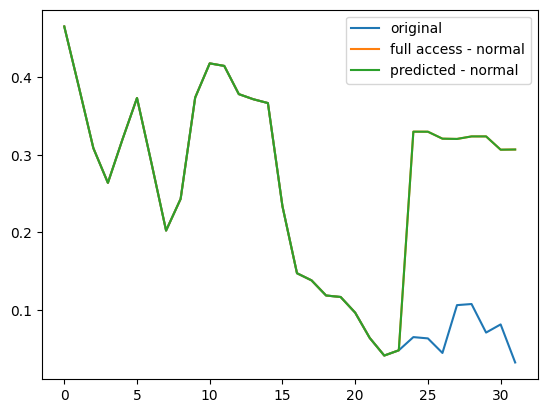

In [8]:
shift, look_back, pred = 10, 24, 8

ones = torch.ones(1, 1, 1)
for model in models:
    model['model'].eval()
    out = ones
    for i in range(pred):
        out = torch.concatenate((out, (model['model'](torch.tensor(training_data[np.newaxis, shift:shift+look_back,:]), out)[:, -1, :]).unsqueeze(1)), dim=1)
    
    output = model['model'](
        torch.tensor(training_data[np.newaxis, shift:shift+look_back,:]),  
        torch.tensor(torch.concat((ones, torch.tensor(training_data[np.newaxis, shift+look_back:shift+look_back+pred-1,:])), dim=1))
    )
    
    plt.plot(training_data.reshape((200,))[shift+look_back:shift+look_back+pred], label='original')
    plt.plot(
        #torch.concatenate(
           # (torch.tensor(training_data[np.newaxis, shift:shift+look_back,:]).reshape((look_back,)), 
             output[:, :, :].detach().reshape((pred,)),#), dim=0), 
        label='full access - normal'
    )
    plt.plot(
        #torch.concatenate(
        #    (torch.tensor(training_data[np.newaxis, shift:shift+look_back,:]).reshape((look_back,)), 
             out[:, 1:, :].detach().reshape((pred,)),#), dim=0),
        label='predicted - normal'
    )
    
#for model in models_decomp:
#    out = torch.ones(1,1,11)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_decomp[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,11)).sum(-1), label='predicted - decomp')

#for model in models_decomp_rem:
#    out = torch.ones(1,1,10)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_decomp_rem[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,10)).sum(-1), label='predicted - rem')

#for model in models_decomp_combined:
#    out = torch.ones(1,1,1)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_combined[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,)), label='predicted - combined')

#for model in models_decomp_combined_rem:
#    out = torch.ones(1,1,1)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_combined_rem[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,)), label='predicted - combined rem')

plt.legend()
plt.show()